# Introduction

For this problem we have data from each quarter of the year 2017. Each file contains data regarding the trip made by a customer on a bike. We will try to answer the questions such as:
    1. What days of the week are most rides taken on?
    2. What bike stations are more popular?
    3. What time of the year, and time of the day are most rides taken on?

Eventually, we will build a model that classifies whether a given user is a casual user or a registered user.

# Exploratory data analysis

First we will combine the four files into one consolidated file on trip history for the entire year of 2017. Next we'll look for NAs and the properties of the columns.

In [1]:
#set the path and fetch files in dataframes
path = "/home/ankit19/Desktop/Jupyter_Notebooks/Bike Sharing/data"
setwd(path)

BSQuat1 = read.csv("2017Q1-capitalbikeshare-tripdata.csv", stringsAsFactors = F)
BSQuat2 = read.csv("2017Q2-capitalbikeshare-tripdata.csv", stringsAsFactors = F)
BSQuat3 = read.csv("2017Q3-capitalbikeshare-tripdata.csv", stringsAsFactors = F)
BSQuat4 = read.csv("2017Q4-capitalbikeshare-tripdata.csv", stringsAsFactors = F)

#Combine data by rows
TripData = rbind(BSQuat1, BSQuat2, BSQuat3, BSQuat4)

#Set seed and shuffle the data
set.seed(999)
TripData = TripData[sample(1:nrow(TripData)), ]
rownames(TripData) = NULL

#First 6 rows
head(TripData)

Duration,Start.date,End.date,Start.station.number,Start.station,End.station.number,End.station,Bike.number,Member.type
3859,2017-06-09 11:44:59,2017-06-09 12:49:19,31293,31st & Water St NW,31314,34th & Water St NW,W21038,Casual
9214,2017-08-04 09:36:02,2017-08-04 12:09:37,31321,15th St & Constitution Ave NW,31269,3rd St & Pennsylvania Ave SE,W22010,Casual
1811,2017-02-23 19:06:47,2017-02-23 19:36:59,31242,18th St & Pennsylvania Ave NW,31102,11th & Kenyon St NW,W22832,Member
605,2017-10-21 14:47:27,2017-10-21 14:57:33,31613,Eastern Market Metro / Pennsylvania Ave & 7th St SE,31622,13th & D St NE,W01085,Member
285,2017-10-02 08:19:09,2017-10-02 08:23:55,31241,Thomas Circle,31278,18th & R St NW,W00269,Member
540,2017-03-07 14:48:53,2017-03-07 14:57:54,31277,17th & G St NW,31256,10th & E St NW,W20088,Member


In [2]:
#Get a summary of the columns in the dataframe
summary(TripData)

#Print the number of rows
print(paste("Number of observations: ", nrow(TripData)))

    Duration      Start.date          End.date         Start.station.number
 Min.   :   60   Length:3757777     Length:3757777     Min.   :31000       
 1st Qu.:  410   Class :character   Class :character   1st Qu.:31205       
 Median :  710   Mode  :character   Mode  :character   Median :31255       
 Mean   : 1153                                         Mean   :31320       
 3rd Qu.: 1226                                         3rd Qu.:31502       
 Max.   :86394                                         Max.   :32225       
 Start.station      End.station.number End.station        Bike.number       
 Length:3757777     Min.   :31000      Length:3757777     Length:3757777    
 Class :character   1st Qu.:31211      Class :character   Class :character  
 Mode  :character   Median :31254      Mode  :character   Mode  :character  
                    Mean   :31321                                           
                    3rd Qu.:31500                                           
      

[1] "Number of observations:  3757777"


So it can be seen that this dataframe is really huge with over 3 million obervations! The good news is that it does not have any NAs but has numerous types of observations in most columns.

# Data manipulation

## Duration
The data available here is in minutes. I think it's best to breakdown these highly variant variables into different categories or buckets. Let's first start with breaking down the "Duration" column. A straightforward approach would be to simply breakdown the column into categories as defined by the quartiles, but it can happen that we will be defining too broad categories so let's first look at the number of occurrences in each quartile.

In [3]:
#Duration in first quartile, less than or equal to 410/60 ~ 6 hours
print(paste("Less than or equal to 6 hours: ", sum(TripData$Duration <= 410)))

#Duration in second quartile, greater than 6 hours and less than and equal to 710/60 ~ 12 hours
print(paste("Between 6 to 12 hours: ", sum(TripData$Duration > 410 & TripData$Duration <= 710)))

#Duration in third quartile, greater than 12 hours and less than and equal to 1226/60 ~ 20 hours
print(paste("Between 12 to 20 hours: ", sum(TripData$Duration > 710 & TripData$Duration <= 1226)))

#Duration in fourth quartile, greater than 20 hours and less than and equal to 86394/3600 ~ 23 days
print(paste("Between 20 hours to 23 days: ", sum(TripData$Duration > 1226 & TripData$Duration < 86394)))

#Let separately see the number of cases for which duration is maximum
print(paste("Equal to 23 days: ", sum(TripData$Duration == 86394)))

[1] "Less than or equal to 6 hours:  940389"
[1] "Between 6 to 12 hours:  940900"
[1] "Between 12 to 20 hours:  937707"
[1] "Between 20 hours to 23 days:  938780"
[1] "Equal to 23 days:  1"


So it is evident that the distribution of duration is the quartiles is about the same, with each quartile having over 900,000 observations. But it is my hypothesis that the casual users are going to be more inclined towards renting the bikes for upto 2 hours or less than 3 hours; hence if we were to make a categorization of less than 6 hours and more users that classify as "Member" are present in that category, than the resultant model will perform poorly in this aspect. 

Building on this I hypothesize the categorizations to be made as following:
    1. Less than or equal to 2 hours
    2. Greater than 2 hours, less than and equal to 4 hours
    3. Greater than 4 hours, less than and equal to 6 hours
    4. Greater than 6 hours, less than and equal to 10 hours
    5. Greater than 10 hours, less than and equal to 12 hours
    6. Greater than 12 hours, less than and equal to 16 hours
    7. Greater than 16 hours, less than and equal to 20 hours
    8. Greater than 20 hours
    
But it'd be imprudent to not look at the distribution of users in these categories first. To do that we implement the use of bar plots.

In [4]:
#Subsetting the dataframes based on quartiles
DurationQ1 <- subset(TripData, Duration <= 410, select=c(Duration, Member.type)) 
DurationQ2 <- subset(TripData, Duration > 410 & Duration <= 710, select=c(Duration, Member.type)) 
DurationQ3 <- subset(TripData, Duration > 710 & Duration <= 1226, select=c(Duration, Member.type)) 
DurationQ4 <- subset(TripData, Duration > 1226, select=c(Duration, Member.type))

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”

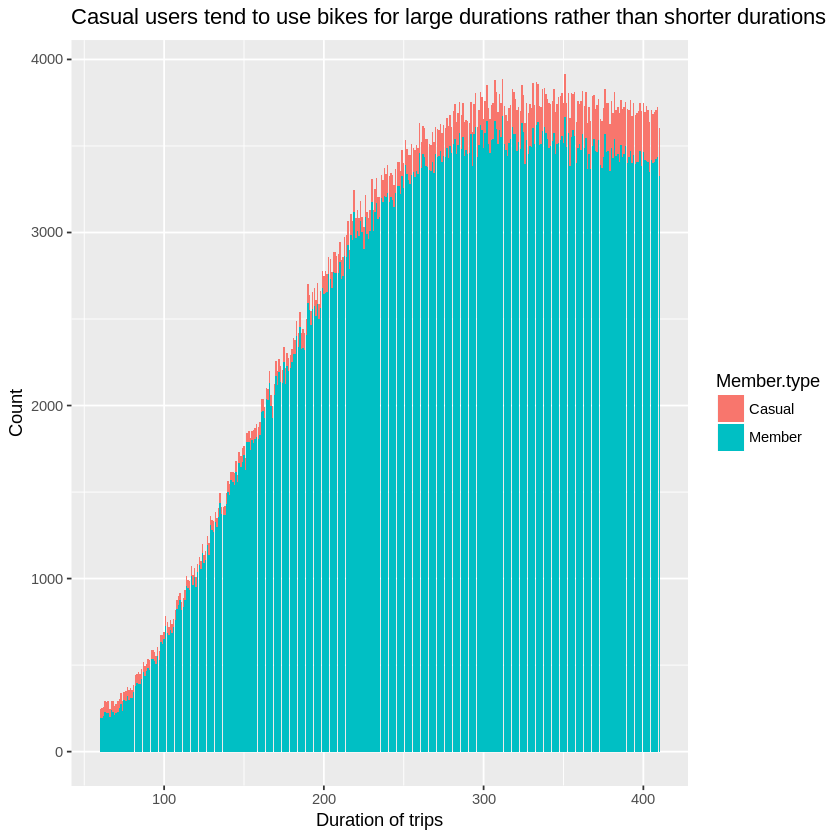

In [5]:
#Importing ggplot2
library(ggplot2)

#Bar plot for first quartile
ggplot(data=DurationQ1, aes(x=Duration, fill=Member.type)) + geom_bar(stat="count") + 
xlab("Duration of trips") + ylab("Count") + ggtitle("Casual users tend to use bikes for large durations rather than shorter durations")

Contrary to my hypothesis, it seems that the number of casual users is more even beyond 2 hours. Surprisingly enough, the number of casual users in the interval of 4 to 6 hours is far more than the interval of 1 to 2 hours. However, the number of member users outnumber the number of casual users by a huge margin and hence we do need to make 3 bifurcations in this 1 to 6 hour interval. Let's observe similar trends in the other quartiles of distribution as well.

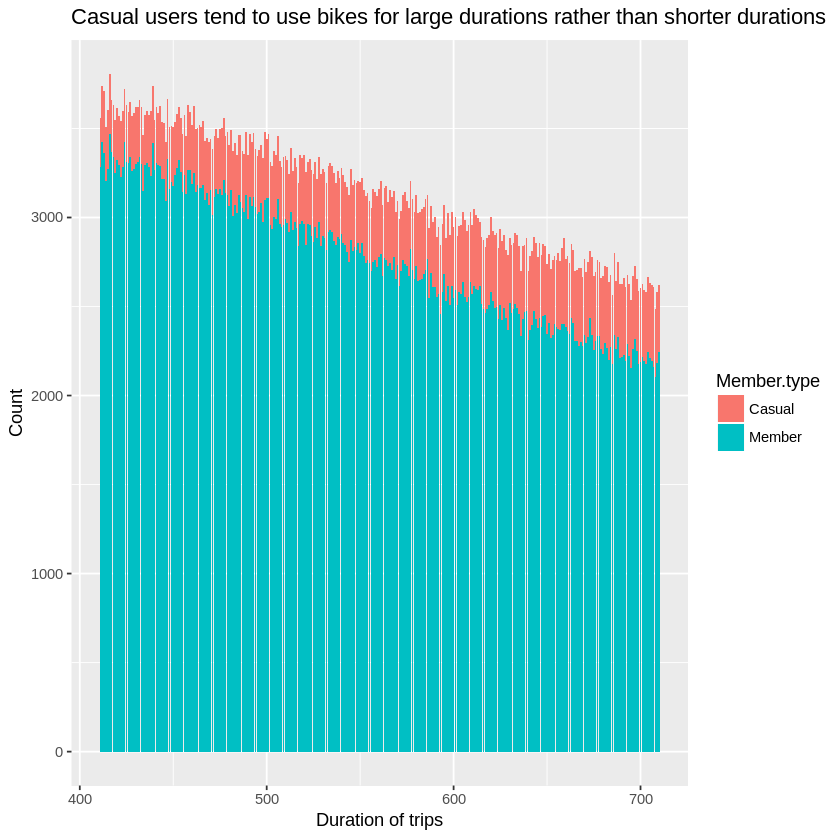

In [6]:
#Bar plot for second quartile
ggplot(data=DurationQ2, aes(x=Duration, fill=Member.type)) + geom_bar(stat="count") + 
xlab("Duration of trips") + ylab("Count") + ggtitle("Casual users tend to use bikes for large durations rather than shorter durations")

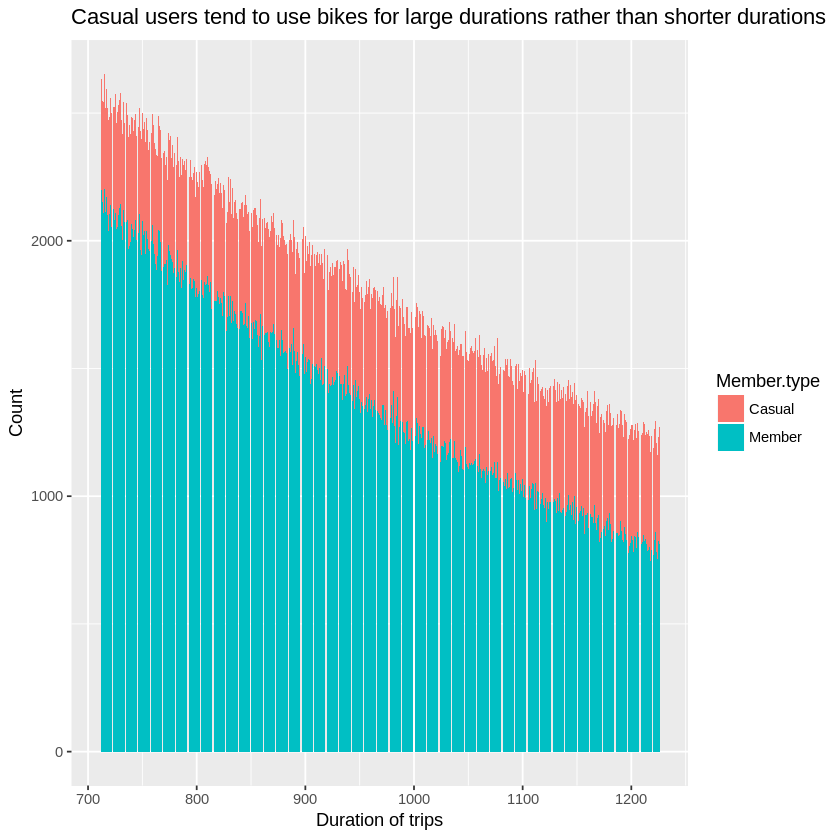

In [7]:
#Bar plot for third quartile
ggplot(data=DurationQ3, aes(x=Duration, fill=Member.type)) + geom_bar(stat="count") + 
xlab("Duration of trips") + ylab("Count") + ggtitle("Casual users tend to use bikes for large durations rather than shorter durations")


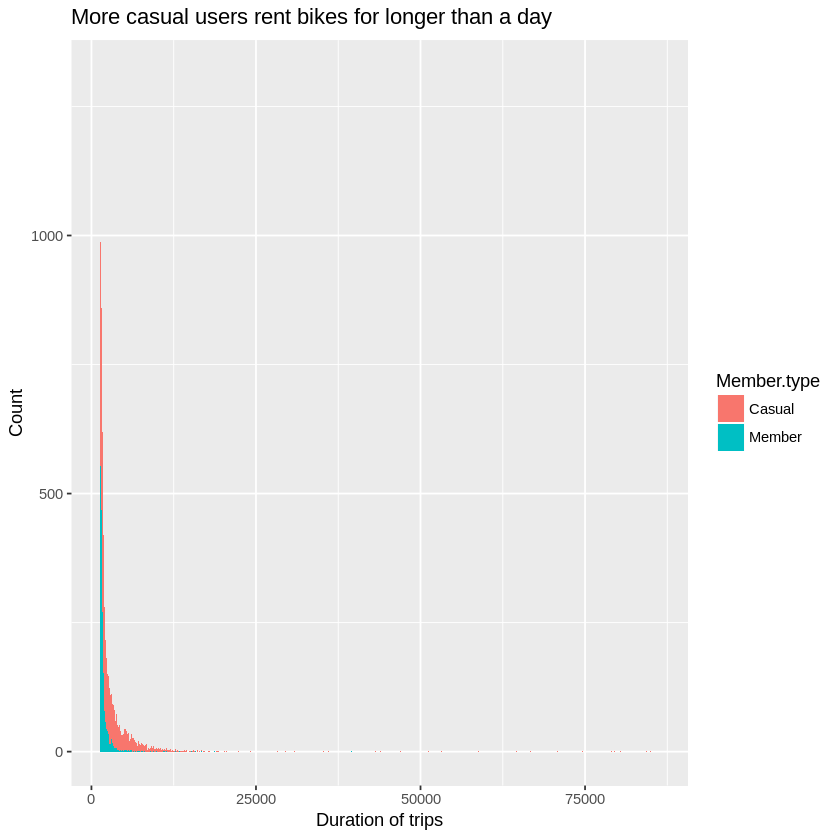

In [8]:
#Bar plot for fourth quartile
ggplot(data=DurationQ4, aes(x=Duration, fill=Member.type)) + geom_bar(stat="count") +
xlab("Duration of trips") + ylab("Count") + ggtitle("More casual users rent bikes for longer than a day")


Some interesting trends can be observed here. I think it is safe to assume that the casual users tend to rent out a bike for far longer durations of time; this evident by the increasing numbers of casual users in the subsequent quartiles. Whereas, the member users tend to rent bikes for shorter to moderate, and moderate high durations of time, instead of extreme durations like more than 20 hours. So now we can move forward with the bifurcation of the duration column into 8 categories.

In [9]:
#Creating a new column Duration_class based on individual conditions

#First quartile
TripData$Duration_class[TripData$Duration <= 120] = "LT2"
TripData$Duration_class[TripData$Duration > 120 & TripData$Duration <= 240 ] = "GT2-LT4"
TripData$Duration_class[TripData$Duration > 240 & TripData$Duration <= 410 ] = "GT4-LT6"

#Second quartile
TripData$Duration_class[TripData$Duration > 410 & TripData$Duration <= 540 ] = "GT6-LT9"
TripData$Duration_class[TripData$Duration > 540 & TripData$Duration <= 710 ] = "GT9-LT12"

#Third quartile
TripData$Duration_class[TripData$Duration > 710 & TripData$Duration <= 960 ] = "GT12-LT16"
TripData$Duration_class[TripData$Duration > 960 & TripData$Duration <= 1226 ] = "GT16-LT20"

#Fourth quartile
TripData$Duration_class[TripData$Duration > 1226] = "GT20"

## Time of the day, day of the week, and month

Now that we have categorized our duration, we should move on to another time variable in our dataset, that is, the start and end time. This data is available in a timestamp format which is not very descriptive. We shall categorize this data in the following categories:

    1. Time of the day -
        a. Midnight (00:00 to 06:00)
        b. Early Morning (06:00 to 10:00)
        c. Noon (10:00 to 14:00)
        d. Mid-day (14:00 to 17:00)
        e. Evening (17:00 to 20:00)
        f. Night (20:00 to 00:00)
    
    2.Day of the week - 
        a. Weekdays (Mon to Fri)
        b. Weekends (Sat and Sun)

    3. Weather - 
        a. Spring (Mar to May)
        b. Summer (Jun to Aug)
        c. Fall (Sep to Nov)
        d. Winter (Dec to Feb)
        
The categorization of time of the day is done with the hypothesis that the casual users tend to use the service during midnight, mid-day, and night times, whereas member users use the service during early morning, and evening (possibly for daily commute). Building on the previous assumption, we can also assume that the service is used more frequently on weekdays, and lesser on weekends. Categorization of the weather is done on the assumption that temperature affects the number of users renting bikes. First we shall parse the information in the column and separate the time of the day and the month from it. Further we shall analyze the trends using different plots.

We can extract all of the information above from our Start.date column. We are only going to consider End.date column for the fourth quartile cases where the duration was over one day. Since we have over 900,000 observations in that quartile as well, we can't ignore the significance of the End.date. We will include a simple binary valued column to define if the bike was rented for more than a day or not.

In [10]:
#Convert the column types to datetime type
TripData$Start.date = as.POSIXlt(TripData$Start.date)
TripData$End.date = as.POSIXlt(TripData$End.date)

#Fetch the hour, the day of the week, and month
TripData$TimeOfDay = as.numeric(TripData$Start.date$hour)
TripData$DayOfWeek = as.numeric(TripData$Start.date$wday)
TripData$Weather = as.numeric(TripData$Start.date$mon)

#Set a binary variable for trips over a day
TripData$OverOneDay = ifelse(difftime(TripData$End.date, TripData$Start.date, units="days") >= 1, 1, 0)

#Define a new column according to the time of the day
TripData$TimeOfDay_class[TripData$TimeOfDay >= 0 & TripData$TimeOfDay < 6] = "Midnight"
TripData$TimeOfDay_class[TripData$TimeOfDay >= 6 & TripData$TimeOfDay < 10] = "Morning"
TripData$TimeOfDay_class[TripData$TimeOfDay >= 10 & TripData$TimeOfDay < 14] = "Noon"
TripData$TimeOfDay_class[TripData$TimeOfDay >= 14 & TripData$TimeOfDay < 17] = "Mid-day"
TripData$TimeOfDay_class[TripData$TimeOfDay >= 17 & TripData$TimeOfDay < 20] = "Evening"
TripData$TimeOfDay_class[TripData$TimeOfDay >=20] = "Night"

#Define a new column for whether the trip was on a weekend or not
TripData$DayOfWeek_class = ifelse(TripData$DayOfWeek >= 1 & TripData$DayOfWeek <= 5, "Weekday", "Weekend")

#Define a new column for assuming the weather during the trip
TripData$Weather_class[TripData$Weather >= 2 & TripData$Weather <= 4] = "Spring"
TripData$Weather_class[TripData$Weather >= 5 & TripData$Weather <= 7] = "Summer"
TripData$Weather_class[TripData$Weather >= 8 & TripData$Weather <= 10] = "Fall"
TripData$Weather_class[TripData$Weather == 11 | TripData$Weather <=1 ] = "Winter"

#Delete the columns that serve no purpose
TripData$Start.date = NULL
TripData$End.date = NULL
TripData$Duration = NULL
TripData$TimeOfDay = NULL
TripData$DayOfWeek = NULL
TripData$Weather = NULL

Now that we have the data in our desired format in terms of day, month, and weather we can now analyze how each of their values affect the classification of the user.

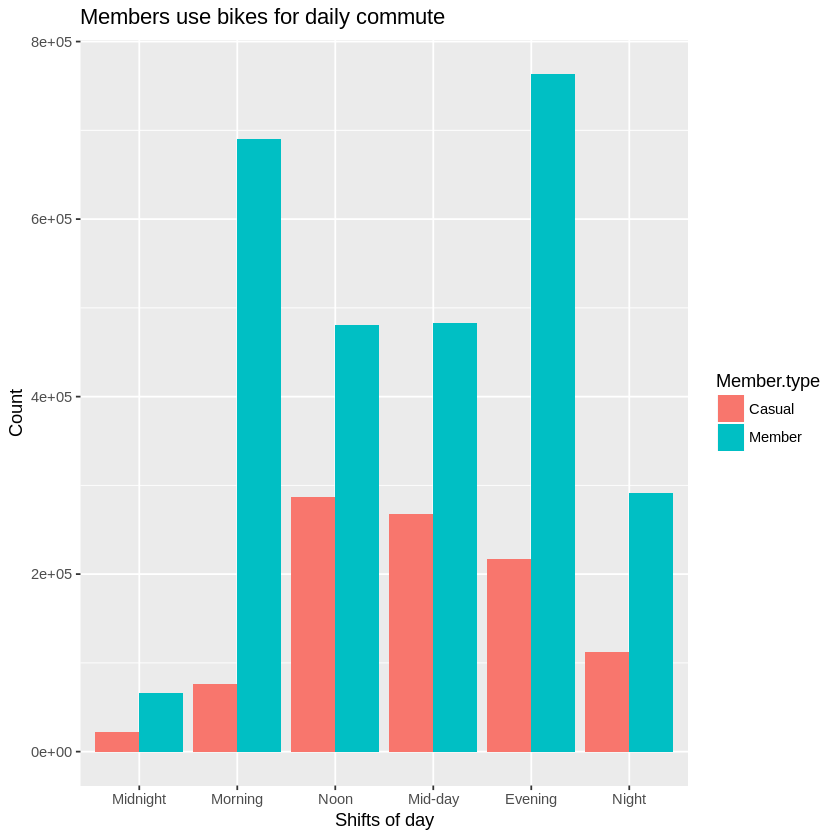

In [11]:
#Subset for obtaining data on shifts, and creating factors
ShiftData = TripData[ ,c("TimeOfDay_class", "Member.type")]
ShiftData$TimeOfDay_class = factor(ShiftData$TimeOfDay_class, levels = c("Midnight", "Morning", "Noon", "Mid-day", "Evening", "Night"))

#Plot data for shift timings
ggplot(data=ShiftData, aes(x=TimeOfDay_class, fill=Member.type)) +
geom_bar(stat="count", position=position_dodge()) + 
xlab("Shifts of day") + ylab("Count") + ggtitle("Members use bikes for daily commute")


From the plot above, it becomes evident that our hypothesis that the members use bikes for their daily commute to the office is true. The high number of members using bikes during the shifts of 06:00 to 10:00, and 17:00 to 20:00 suggests the same.

Similarly, the casual users seem to use the bikes in odd hours of the day much more than the prime hours.

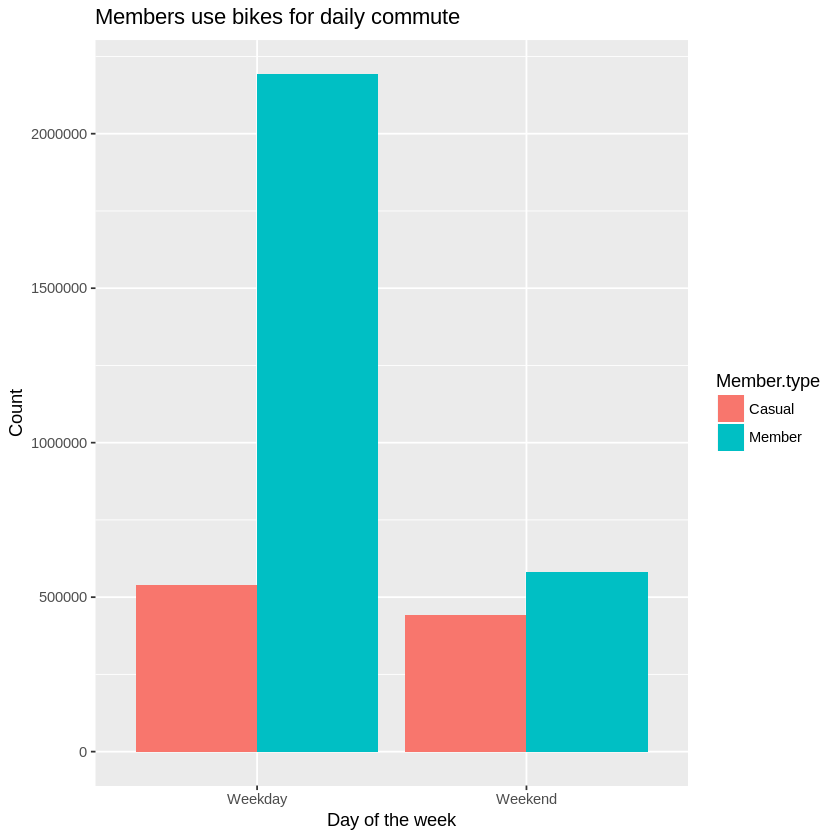

In [12]:
#Plot data for day of the week
ggplot(data=TripData, aes(x=DayOfWeek_class, fill=Member.type)) +
geom_bar(stat="count", position=position_dodge()) + xlab("Day of the week") + ylab("Count") + ggtitle("Members use bikes for daily commute")

This plot proves our hypothesis that members use bikes for daily commute much more than casual users do. We can see that there's a huge difference in the number of bikes used by members on weekdays and number of bikes used by members on weekend. Similar trend is observed among casual users although the difference in the number of bikes used on weekdays vs weekend isn't as significant.

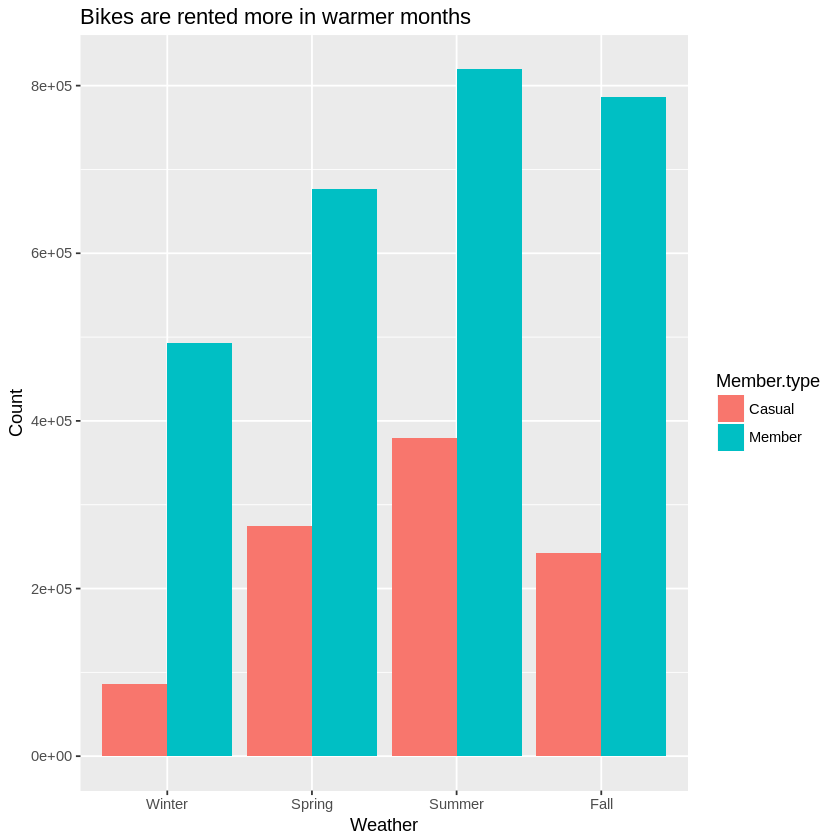

In [13]:
#Subset for obtaining data on different weathers, and creating factors
WeatherData = TripData[ ,c("Weather_class", "Member.type")]
WeatherData$Weather_class = factor(WeatherData$Weather_class, levels = c("Winter", "Spring", "Summer", "Fall"))

#Plot data for weather types
ggplot(data=WeatherData, aes(x=Weather_class, fill=Member.type)) +
geom_bar(stat="count", position=position_dodge()) + xlab("Weather") + ylab("Count") + ggtitle("Bikes are rented more in warmer months")


Again, the hypothesis that people rent bikes more during warmer months is pretty evident from the plot that we have here. The number of users in both the categories increases from spring to summer and then declines with the onset of fall. Although, this decline is much more significant in the number of casual users than with members.

## Start and end location

Now that we have dealed with temporal data in the dataset, let's move on to the spatial data. Here the hypothesis is that we may have some source stations that are more popular than others. Same can be inferred about the end stations. But instead of looking at source and destination stations independently, I think it will be better to observe the routes and their popularity directly. For this we first need to extract routes, then count the occurrences of each of these routes. Once we have done that, we will be able to proceed further.

I am only considering the Start.station.number and End.station.number values because I wasn't sure about using the station's name, and address due to lack of proper information in those fields. If there was proper information as to where these stations were located, I could have plotted the stations on maps. Also, I think there's no need to consider routes popularity for different class of users as the popularity index will convey enough information about a route, and the classification algorithm will be able to identify the whether the route is popular amongst the members or casual users.

In [15]:
#Library for data manipulation
library(dplyr)

#A new column that stores the route as character
#This is essential because a route may be popular only in one direction
TripData$Route = paste(as.character(TripData$Start.station.number), as.character(TripData$End.station.number), sep="-")

TripData = TripData %>%        #with TripData..
    group_by(Route) %>%        #group rows by column Route
    mutate(RouteCount = n())   #count occurrences of each route and store in new column RouteCount

head(TripData)

Warning message:
“package ‘dplyr’ was built under R version 3.4.4”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Start.station.number,Start.station,End.station.number,End.station,Bike.number,Member.type,Duration_class,OverOneDay,TimeOfDay_class,DayOfWeek_class,Weather_class,Route,RouteCount
31293,31st & Water St NW,31314,34th & Water St NW,W21038,Casual,GT20,0,Noon,Weekday,Summer,31293-31314,288
31321,15th St & Constitution Ave NW,31269,3rd St & Pennsylvania Ave SE,W22010,Casual,GT20,0,Morning,Weekday,Summer,31321-31269,83
31242,18th St & Pennsylvania Ave NW,31102,11th & Kenyon St NW,W22832,Member,GT20,0,Evening,Weekday,Winter,31242-31102,55
31613,Eastern Market Metro / Pennsylvania Ave & 7th St SE,31622,13th & D St NE,W01085,Member,GT9-LT12,0,Mid-day,Weekend,Fall,31613-31622,1477
31241,Thomas Circle,31278,18th & R St NW,W00269,Member,GT4-LT6,0,Morning,Weekday,Fall,31241-31278,426
31277,17th & G St NW,31256,10th & E St NW,W20088,Member,GT6-LT9,0,Mid-day,Weekday,Spring,31277-31256,146


In [16]:
summary(TripData$RouteCount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    79.0   190.0   454.5   439.0  7458.0 

We could simply define 4 levels of popularity index on this summary of counts, but it may be too broad. Hence, I think we should look at each of the quartiles, just like for "Duration" variable, and then define our index for popularity of routes. 

In [19]:
RouteQ1 = subset(TripData, TripData$RouteCount <= 79)
summary(RouteQ1$RouteCount)

RouteQ2 = subset(TripData, TripData$RouteCount>79 & TripData$RouteCount<=190)
summary(RouteQ2$RouteCount)

RouteQ3 = subset(TripData,TripData$RouteCount>190 & TripData$RouteCount<=439)
summary(RouteQ3$RouteCount)

RouteQ4 = subset(TripData, TripData$RouteCount > 439)
summary(RouteQ4$RouteCount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   19.00   38.00   39.02   58.00   79.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   80.0   103.0   127.0   129.8   156.0   190.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  191.0   230.0   282.0   292.3   350.0   439.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    440     589     837    1360    1553    7458 

So given the distribution of values in the data, it seems wiser to break down each quartile into two indexes each. Thus we define a new column named "RoutePopularityIndex" that stores a numeric value ranging from 1 to 8; here higher the number, higher is the route's popularity.

In [20]:
TripData$RoutePopularityIndex[TripData$RouteCount <= 38 ] = 1
TripData$RoutePopularityIndex[TripData$RouteCount > 38 & TripData$RouteCount <= 79 ] = 2
TripData$RoutePopularityIndex[TripData$RouteCount > 79 & TripData$RouteCount <= 127 ] = 3
TripData$RoutePopularityIndex[TripData$RouteCount > 127 & TripData$RouteCount <= 190 ] = 4
TripData$RoutePopularityIndex[TripData$RouteCount > 190 & TripData$RouteCount <= 282 ] = 5
TripData$RoutePopularityIndex[TripData$RouteCount > 282 & TripData$RouteCount <= 439 ] = 6
TripData$RoutePopularityIndex[TripData$RouteCount > 439 & TripData$RouteCount <= 837 ] = 7
TripData$RoutePopularityIndex[TripData$RouteCount > 837 & TripData$RouteCount <= 7458 ] = 8

Warning message:
“Unknown or uninitialised column: 'RoutePopularityIndex'.”

Now that we have defined our new parameter to categorize routes, let's fetch the unique routes and try and plot those on a heatmap.

In [22]:
topRoutes = TripData %>%          #with TripData, select some columns..
        select(Start.station.number, Start.station, End.station.number, End.station, Route, RouteCount) %>%
        distinct() %>%            #find unique rows..
        arrange(desc(RouteCount)) #arrange them in descending order based on RouteCount
        
nrow(topRoutes)

[1] 72943

The dataframe "topRoutes" shows that there are 72,943 unique routes that exist. The sheer magnitude of it is too much to plot a readable heatmap based on their RouteCount values. Hence, a more effecient way would be to store the values in a different dataframe, which if required can be stored as a csv file as well.

In [23]:
#Display and store the top 100 routes
head(topRoutes, n=100)
topRoutes = head(topRoutes, n=100)

Start.station.number,Start.station,End.station.number,End.station,Route,RouteCount
31247,Jefferson Dr & 14th St SW,31247,Jefferson Dr & 14th St SW,31247-31247,7458
31258,Lincoln Memorial,31249,Jefferson Memorial,31258-31249,7166
31248,Smithsonian-National Mall / Jefferson Dr & 12th St SW,31248,Smithsonian-National Mall / Jefferson Dr & 12th St SW,31248-31248,6729
31247,Jefferson Dr & 14th St SW,31258,Lincoln Memorial,31247-31258,6368
31258,Lincoln Memorial,31258,Lincoln Memorial,31258-31258,5193
31258,Lincoln Memorial,31247,Jefferson Dr & 14th St SW,31258-31247,5173
31248,Smithsonian-National Mall / Jefferson Dr & 12th St SW,31258,Lincoln Memorial,31248-31258,4383
31290,17th St & Independence Ave SW,31258,Lincoln Memorial,31290-31258,4186
31623,Columbus Circle / Union Station,31631,8th & F St NE,31623-31631,4145
31249,Jefferson Memorial,31258,Lincoln Memorial,31249-31258,4029


So it seems that the station named "Jefferson Dr & 14th St SW" is the most popular amongst the users with an enormous RouteCount of 7458!

Now we will drop the columns of start station's name & number, the end station's name & number, and the RouteCount.

In [24]:
#Dropping old columns
TripData$Start.station.number = NULL
TripData$End.station.number = NULL
TripData$Start.station = NULL
TripData$End.station = NULL
TripData$RouteCount = NULL

#Rearranging the columns
TripData = TripData[, c("Bike.number", "Route", "RoutePopularityIndex", "Duration_class", "TimeOfDay_class", "DayOfWeek_class", "OverOneDay", "Weather_class", "Member.type")]
head(TripData)

Bike.number,Route,RoutePopularityIndex,Duration_class,TimeOfDay_class,DayOfWeek_class,OverOneDay,Weather_class,Member.type
W21038,31293-31314,6,GT20,Noon,Weekday,0,Summer,Casual
W22010,31321-31269,3,GT20,Morning,Weekday,0,Summer,Casual
W22832,31242-31102,2,GT20,Evening,Weekday,0,Winter,Member
W01085,31613-31622,8,GT9-LT12,Mid-day,Weekend,0,Fall,Member
W00269,31241-31278,6,GT4-LT6,Morning,Weekday,0,Fall,Member
W20088,31277-31256,4,GT6-LT9,Mid-day,Weekday,0,Spring,Member


Now that we are done with all the necessary data manipulations, it seems best to store this refined dataframe in a csv file to be used for further analysis (next Jupyter Notebook). We'll also store the information on top 100 routes. 

In [29]:
#writing refined data to csv file
write.csv(TripData, "TripData.csv", row.names=FALSE)

#writing info on popular routes to csv file
write.csv(topRoutes, "Top100Routes.csv", row.names=FALSE)

# Model building

In this section we will be building a model using Decision Trees. We will compare the performance of the model on both the training and testing data using confusion matrix made by gmodels package. So let's first start with importing the refined data after data manipulations and then splitting it into training and testing data.

In [1]:
#set the path and fetch files in dataframes
path = "/home/ankit19/Desktop/Jupyter_Notebooks/Bike Sharing/data"
setwd(path)

TripData = read.csv("TripData.csv", stringsAsFactors = F)
#Bike number serves no purpose so we drop it
TripData$Bike.number = NULL
summary(TripData)

    Route           RoutePopularityIndex Duration_class     TimeOfDay_class   
 Length:3757777     Min.   :1.000        Length:3757777     Length:3757777    
 Class :character   1st Qu.:2.000        Class :character   Class :character  
 Mode  :character   Median :4.000        Mode  :character   Mode  :character  
                    Mean   :4.494                                             
                    3rd Qu.:6.000                                             
                    Max.   :8.000                                             
 DayOfWeek_class      OverOneDay    Weather_class      Member.type       
 Length:3757777     Min.   :0e+00   Length:3757777     Length:3757777    
 Class :character   1st Qu.:0e+00   Class :character   Class :character  
 Mode  :character   Median :0e+00   Mode  :character   Mode  :character  
                    Mean   :5e-07                                        
                    3rd Qu.:0e+00                                        
   

Before we move ahead with splitting the data, I think we should consider the value of the "Route" column. From our data manipulation process we know that there are about 72000 unique routes. This may be too much for a decision tree or any other classification algorithm. We can confirm that by trying to make one-hot coding for Routes.

In [3]:
#Making one-hot coding matrix
#route_matrix = model.matrix(~Route-1, TripData)

Execution of the code above throws an From the error stating that a vector of size 39.6 Gb can't be made. This makes it evident that we cannot use this column for our predictions. Thankfully, the column "RoutePopularityIndex" will preserve the valuable information provided by the "Route" column. Hence, we'll drop the "Route" column and split the data into a 75% training data and 25% testing data.

<b>Note:</b> Executing that line of code makes the file larger than 25 Mb, making it impossible to upload on GitHub hence I've commented that line of code.

In [3]:
#Subset without Route information
CopyTripData = subset(TripData, select = -c(Route))

#Storing the classification labels
TripLabels = CopyTripData$Member.type

index = round(nrow(CopyTripData) * 0.75)

#Training set and respective labels
TrainSet = CopyTripData[1:index, ]
TrainLabels = TripLabels[1:index]

#Testing set and respective labels
TestSet = CopyTripData[-(1:index), ]
TestLabels = TripLabels[-(1:index)]

## Decision Tree

We will make a decision tree model using rpart package. Decision trees are favoured due to their simplicity and effeciency in classification problems of large datasets. Since our dataset is quite large (close to 4 million), using decision tree seems wise.

In [4]:
library(rpart)
decisionTree = rpart(Member.type ~ RoutePopularityIndex + Duration_class + TimeOfDay_class + DayOfWeek_class + Weather_class + OverOneDay, data=TrainSet, method="class")
printcp(decisionTree)

Warning message:
“package ‘rpart’ was built under R version 3.4.4”


Classification tree:
rpart(formula = Member.type ~ RoutePopularityIndex + Duration_class + 
    TimeOfDay_class + DayOfWeek_class + Weather_class + OverOneDay, 
    data = TrainSet, method = "class")

Variables actually used in tree construction:
[1] DayOfWeek_class      Duration_class       RoutePopularityIndex

Root node error: 736686/2818333 = 0.26139

n= 2818333 

        CP nsplit rel error  xerror       xstd
1 0.252033      0   1.00000 1.00000 0.00100130
2 0.041736      1   0.74797 0.74797 0.00090377
3 0.010000      3   0.66450 0.66450 0.00086333


From this trained model we can calculate the classification accuracy of the model. We get the misclassification rate as (root node error x xerror x 100) hence we get a misclassification rate of (0.26139 x 0.74797 x 100) = 19.55%. Thus our model has a classification accuracy of 80.45%. Let's see how the model performs on testing data.

In [5]:
#Prediciting using trained model
pred_Trips = predict(decisionTree, TestSet, type="class")

library(gmodels)
CrossTable(x=TestLabels, y=pred_Trips, prop.chisq=FALSE)

Warning message:
“package ‘gmodels’ was built under R version 3.4.4”


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  939444 

 
             | pred_Trips 
  TestLabels |    Casual |    Member | Row Total | 
-------------|-----------|-----------|-----------|
      Casual |    118344 |    126768 |    245112 | 
             |     0.483 |     0.517 |     0.261 | 
             |     0.763 |     0.162 |           | 
             |     0.126 |     0.135 |           | 
-------------|-----------|-----------|-----------|
      Member |     36796 |    657536 |    694332 | 
             |     0.053 |     0.947 |     0.739 | 
             |     0.237 |     0.838 |           | 
             |     0.039 |     0.700 |           | 
-------------|-----------|-----------|-----------|
Column Total |    155140 |    784304 |    939444 | 
             |     0.165 |     0.835 |           | 
-------------|--

Accuracy is calculated as (True Positives + True Negatives)/Total.
Hence, Accuracy = (118344 + 657536)/939444 = 0.8259 i.e. 82.59% 

The model performed even better with the testing data, which is amazing!

<b>Note:</b> I intended to build different models based on logistic regression, random forest, and kNN algorithm but due to the sheer volume of data my system couldn't handle it. I have even tried xgboosting but the system would freeze. Due to the limitations of my system, and since the classification accuracy of the decision tree model is over 80%, I have chosen to end this project here.